<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2020_2021/blob/main/LaRanceExample/LaRance_ebb_TurbineGeneratorControl_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import numpy as np

In [2]:
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (12, 3)

## Turbine hill map and turbine operating curve
 
<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/TurbineHill_Plot.svg" width="400px" style="display:inline">

In [3]:
class Turbine:

  def __init__( self ):
    self.poly_CQ1 = np.poly1d( np.array([0.16928201, 0.08989368]) )
    self.poly_CQ2 = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03, 
                                         -9.25873626e-02,  1.75687197e+00]) )

    self.poly_CE1 = np.poly1d( np.array([-0.02076456, 0.20238444, 0.48984553]) )
    self.poly_CE2 = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,  
                                         6.86081825e-04,  7.93083108e-01]) )

  def Q11( self, n11 ):
    assert( n11 >= 4.38 and n11 <= 17.17 )
    if n11 < 7.92193025936073:
      return self.poly_CQ1( n11 ) 
    else:
      return self.poly_CQ2( n11 )

  def eta( self, n11 ):
    assert( n11 >= 4.38 and n11 <= 17.17 )
    if n11 < 7.92193025936073:
      return self.poly_CE1( n11 ) * 0.912
    else:
      return self.poly_CE2( n11 ) * 0.912

## Generator efficiency curve

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/GeneratorEff_plot.svg" width="400px" style="display:inline">


In [4]:
class Generator:

  def __init__( self ):
    self.poly_C1 = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03, 
                                        -3.80834059e+02,  2.70423225e+01, 
                                        3.29394948e-03]) )
    self.poly_C2 = np.poly1d( np.array([-1.16856952,  3.31172525, -3.44296217,  
                                        1.5416029 ,  0.71040716]) )
      
  def eta( self, load ):
    assert( load >= 0 and load <= 1.0 )
    if load < 0.125423729:
      return self.poly_C1( load ) 
    else:
      return self.poly_C2( load ) 

## Power plant operation finite state machine
 
<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/LaRanceExample/EbbOperation.svg" width="700px" style="display:inline">

In [16]:
class Inputs_FSM:
    h: float 
    h_min: float 
    n11: float 
    n11_max: float     

class EbbOperations_FSM:

    def __init__( self ):
        self.transitions = { 0:self.__transition_0_1, 
                             1:self.__transition_1_2,
                             2:self.__transition_2_3,
                             3:self.__transition_3_4,
                             4:self.__transition_4_1 }
        self.cur_state = 0

    def transition( self, inputs ):
        self.transitions[ self.cur_state ]( inputs )
        return self.cur_state

    def current_state( self ):
        return self.cur_state

    def __transition_0_1( self, inputs ):
        if ( inputs.h - inputs.h_min ) > 0.0:
            self.cur_state = 1

    def __transition_1_2( self, inputs ):
        if ( inputs.n11 - inputs.n11_max ) >  0.0:
            self.cur_state = 2

    def __transition_2_3( self, inputs ):
        if inputs.h < 0.0:
            self.cur_state = 3

    def __transition_3_4( self, inputs ):
        if inputs.h > 0.0:
            self.cur_state = 4

    def __transition_4_1( self, inputs ):
        if ( inputs.h - inputs.h_min ) > 0.0:
            self.cur_state = 1

Declare constants

In [6]:
π = np.pi
two_π = 2.0 * π
ga = 9.8 # gravity aceleration
ρw = 1025.0 # water density

"La Rance" data

In [7]:
S_bas = 22.0 * 1000.0**2 # basin area [m^2]
n_turbs = 24 # number of turbines
n_gates = 6  # number of sluice gates
G_ε = 2025.0 # ( n_gates * Q_sluices + n_turbs * Q_turb ) / sqrt( 2g H_rated)
D_turb = 5.35
CT1 = D_turb**2 * np.sqrt( ga )

Power plant data

In [8]:
A_gates = 10*15 * n_gates # Sluice gates area
A_turbs = π*(D_turb/2)**2 * n_turbs # Turbines area

Omega = 93.75 * π / 30.0  # turbine rotational speed
Turb = Turbine()

# minimum h for turbine starting
h_min = 8

In [9]:
Pgen_rated = 60E6 # Power plant electrical generator rated power

Gen = Generator()

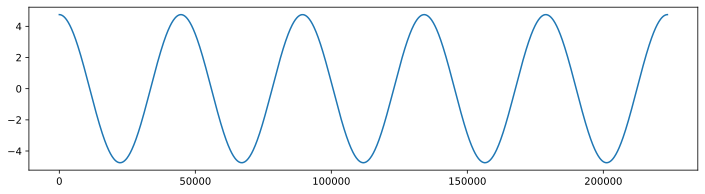

In [10]:
ζ_tid = 4.75 # tide amplitude
Per = 12.0*3600.0 + 25.2*60.0
kp = 5 # number of periods

# time points
t_vec  = np.linspace( 0.0, kp*Per, kp*300 )
delta_t = t_vec[1]

# the tidel level
y_vec = ζ_tid * np.cos( two_π * t_vec / Per )

mpl.plot( t_vec, y_vec );

In [11]:
inputs = Inputs_FSM()
inputs.h_min = 7.0
inputs.n11_max = 17.0

EO_FSM = EbbOperations_FSM()

u_vec = np.zeros( t_vec.size )  # control stages
P_vec = np.zeros( t_vec.size )  # instantaneous power
V_vec = np.zeros( t_vec.size )  # volume vector
Q_vec = np.zeros( t_vec.size )  # flow rate vector
ηT_vec = np.zeros( t_vec.size )  # turbine efficiency vector
ηG_vec = np.zeros( t_vec.size )  # generator efficiency vector

V_vec[0] = S_bas * 5.0 # initial volume in the basin

for i in range( 1, len( t_vec ) ): 
  t  = t_vec[i]  
  z0 = V_vec[i-1] / S_bas 
  h  = z0 - y_vec[i]  
  n11 = Omega * D_turb / np.sqrt( ga * np.max( [h,0] ) )

  inputs.h = h
  inputs.n11 = n11

  state = EO_FSM.transition( inputs )
      
  if state == 1:
      Q = n_turbs * CT1 * Turb.Q11( n11 ) * np.sqrt( h )
      ηT = Turb.eta( n11 )
      PT = η * ρw * ga * h * Q
      ηG = Gen.eta( PT / ( n_turbs * Pgen_rated ) )
  elif state == 2:
      Q = 0
      ηT = 0
      PT = 0
      ηG = 0
  elif state == 3:
      Q = -G_ε*np.sqrt( 2.0 * ga * np.abs(h) )
      ηT = 0
      PT = 0
      ηG = 0
  elif state == 4:
      Q = 0
      ηT = 0
      PT = 0
      ηG = 0

  u_vec[i] = state
  V_vec[i] = V_vec[i-1] - delta_t * Q
  
  Q_vec[i] = Q
  PT_vec[i] = PT
  ηT_vec[i] = ηT
  ηG_vec[i] = ηG

PT_avg = np.mean( PT_vec ) / 1E6
PT_max = np.max( PT_vec ) / 1E6
C_fac = PT_avg / PT_max

print( "Power = %.2f MW" % P_avg ) 
print( "Max P(t) = %.2f MW" % P_max ) 
print( "Cap factor = %.2f" % C_fac ) 

Power = 115.87 MW
Max P(t) = 492.41 MW
Cap factor = 0.24


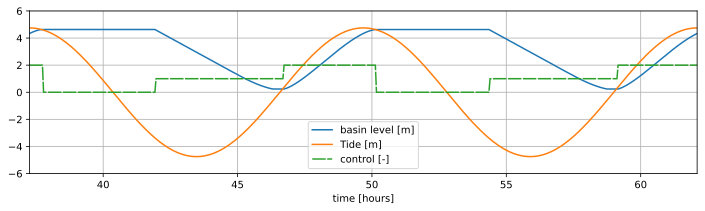

In [12]:
mpl.plot( t_vec/3600, V_vec/S_bas, label='basin level [m]' )
mpl.plot( t_vec/3600, y_vec, label='Tide [m]' )
mpl.plot( t_vec/3600, u_vec, label='control [-]', dashes=(9,1) )
mpl.xlim( 3*Per/3600, 5*Per/3600 )
mpl.ylim( -6, 6 )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.grid();

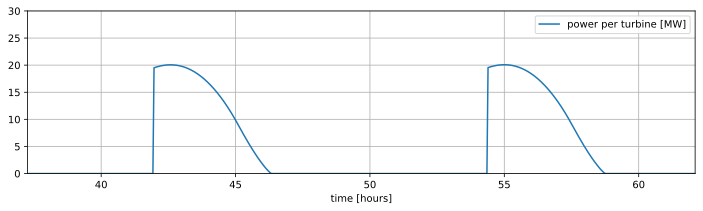

In [13]:
mpl.plot( t_vec/3600, P_vec/(1e6*n_turbs), label='power per turbine [MW]'  )
mpl.xlim( 3*Per/3600, 5*Per/3600 )
mpl.ylim( 0, 30 )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.grid();

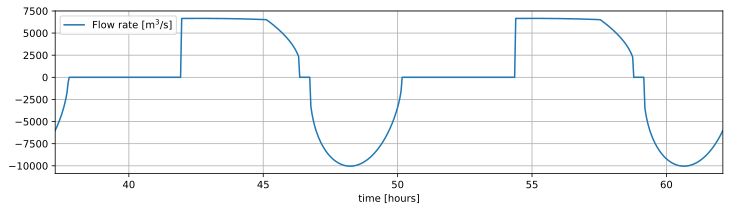

In [14]:

mpl.plot( t_vec/3600, Q_vec, label='Flow rate [m$^3$/s]' )
mpl.xlim( 3*Per/3600, 5*Per/3600 )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.grid();

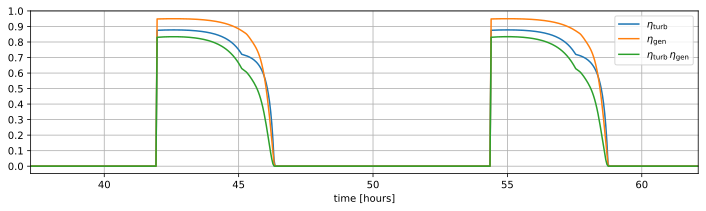

In [15]:
mpl.plot( t_vec/3600, ηT_vec, label='$\eta_\mathrm{turb}$' )
mpl.plot( t_vec/3600, ηG_vec, label='$\eta_\mathrm{gen}$' )
mpl.plot( t_vec/3600, ηT_vec*ηG_vec, label='$\eta_\mathrm{turb}\,\eta_\mathrm{gen}$' )
mpl.xlim( 3*Per/3600, 5*Per/3600 )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.gca().set_yticks(np.arange( 0, 1.01, 0.1) )
mpl.grid();